In [1]:
import os
import sys

sys.executable = os.path.join('/home/rfpred/envs/rfenv', 'bin', 'python3.11')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages')
# sys.path.append('/home/wscheurer/.cache/pip/wheels/16/98/c7/c418dff5bb3004cac4ca78b0b55141ea7cf9b428b613226970') # pprint?

print(sys.path)
%pwd

['/home/rfpred/notebooks', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages']


'/home/rfpred/notebooks'

In [2]:
n_subjects = len(os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata'))

In [3]:
# import all the functions within imgproc.py
# If possible, add separate markdown parts where I illustrate the working of every function. But for now this is not 
# a priority whatsoever.

from funcs.rf_tools import (get_dat, calculate_sigma, calculate_pRF_location, prf_plots_new, prf_plots, make_visrois_dict, 
                            make_gaussian_2d, make_circle_mask, css_gaussian_cut, roi_filter, write_prf_dict, compare_radius, 
                            get_mask, compare_masks, prf_heatmap, get_img_prf, nsd_R2_dict, rsq_to_size, rsquare_selection)
from funcs.utility import print_dict_structure, print_large
from funcs.imgproc import show_stim

In [4]:
print(sys.version)

3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:43:09) [GCC 12.3.0]


Load in all the mapped visual roi masks, store them all in a dictionary.

In [5]:
vismask_dict = make_visrois_dict(vox_count = 'y', bin_check = 'y', n_subjects=n_subjects)

print_dict_structure(vismask_dict)

Subject 1
V1_mask
Non-zero voxels in V1_mask: 7887
V2_mask
Non-zero voxels in V2_mask: 8296
V3_mask
Non-zero voxels in V3_mask: 7022
V4_mask
Non-zero voxels in V4_mask: 3976
V1_mask: 1
V2_mask: 1
V3_mask: 1
V4_mask: 1
Subject 2
V1_mask
Non-zero voxels in V1_mask: 6476
V2_mask
Non-zero voxels in V2_mask: 6376
V3_mask
Non-zero voxels in V3_mask: 6236
V4_mask
Non-zero voxels in V4_mask: 2887
V1_mask: 1
V2_mask: 1
V3_mask: 1
V4_mask: 1
Subject 3
V1_mask
Non-zero voxels in V1_mask: 7358
V2_mask
Non-zero voxels in V2_mask: 6721
V3_mask
Non-zero voxels in V3_mask: 5316
V4_mask
Non-zero voxels in V4_mask: 2486
V1_mask: 1
V2_mask: 1
V3_mask: 1
V4_mask: 1
Subject 4
V1_mask
Non-zero voxels in V1_mask: 5119
V2_mask
Non-zero voxels in V2_mask: 5088
V3_mask
Non-zero voxels in V3_mask: 4669
V4_mask
Non-zero voxels in V4_mask: 2790
V1_mask: 1
V2_mask: 1
V3_mask: 1
V4_mask: 1
Subject 5
V1_mask
Non-zero voxels in V1_mask: 6502
V2_mask
Non-zero voxels in V2_mask: 6309
V3_mask
Non-zero voxels in V3_mask: 

In [6]:
# Not necessary anymore, the masks are already binary.

# bin_masks = binarize_mask(mask_imgs, mask_dir = mapped_masks_dir, threshold = .5, vox_count = 'y')


In [7]:
prf_dict = write_prf_dict(binary_masks = vismask_dict)
R2_dict = nsd_R2_dict(vismask_dict)


prf_rsq_dict = rsquare_selection(prf_dict, 1000, n_subjects = n_subjects, dataset = 'prf')
nsd_rsq_dict = rsquare_selection(R2_dict, 1000, n_subjects = n_subjects, dataset = 'nsd')


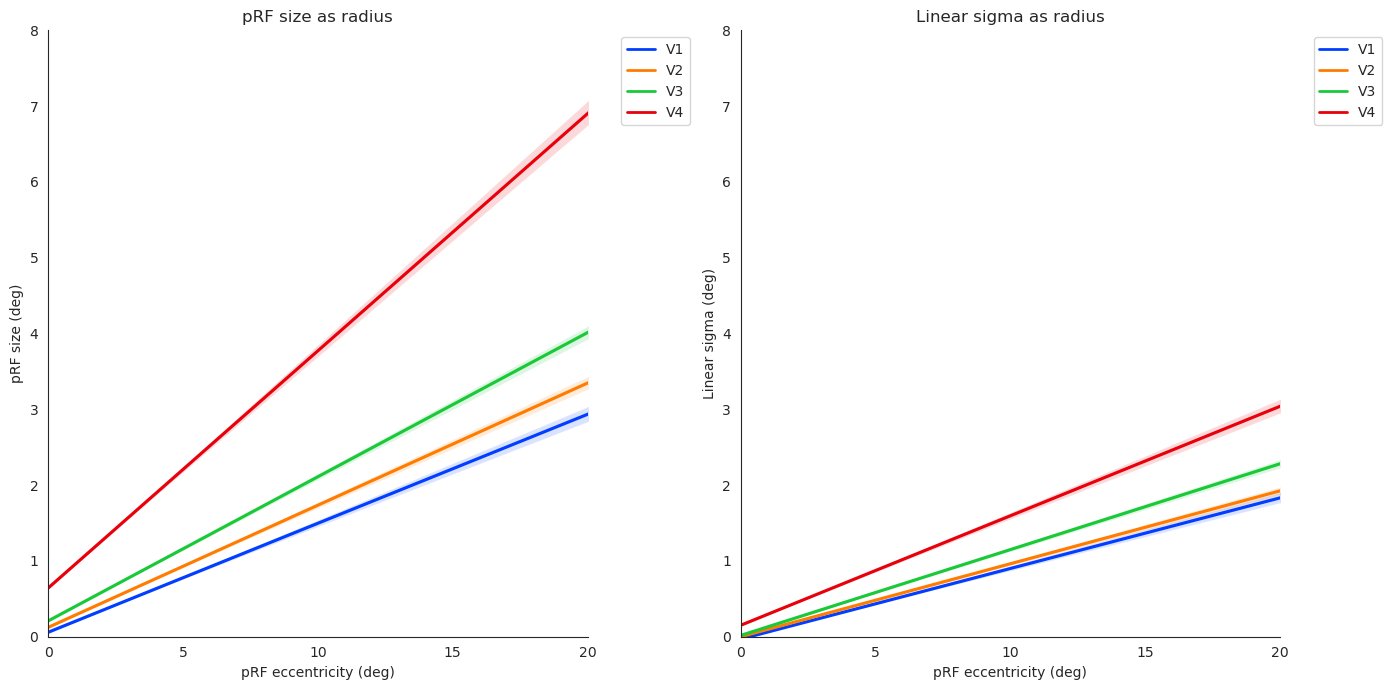

In [8]:
size_ecc = compare_radius(prf_dict)

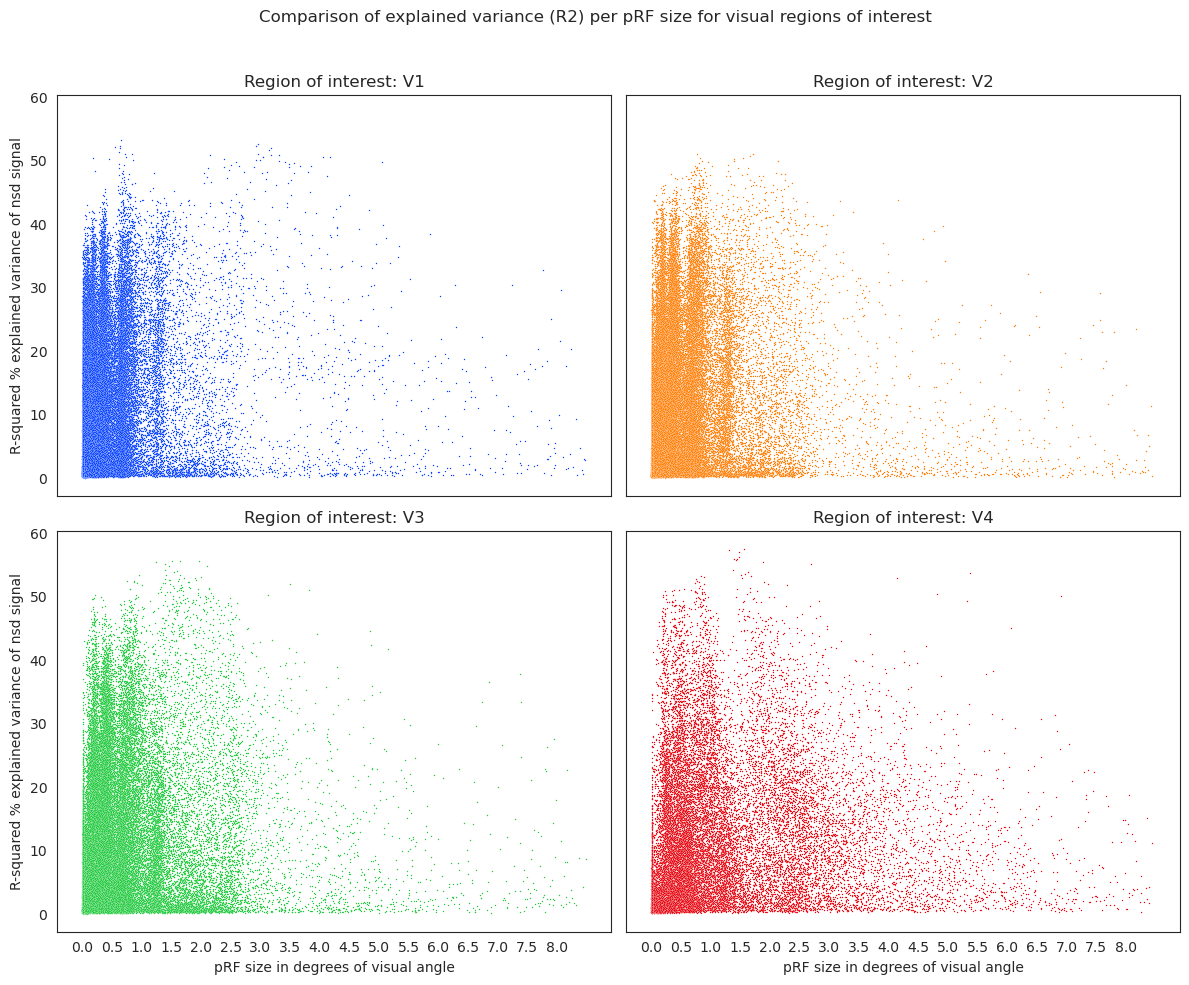

In [9]:
# Compare nsd R2 to pRF size, within range that we're looking at (approximately)
df = rsq_to_size(prf_dict=prf_dict, vismask_dict=vismask_dict, rsq_type = 'nsd')


This needs to be fixed still, so it works for all the subjects. and also so the plots actually make sense and I can select what values I want to plot. 

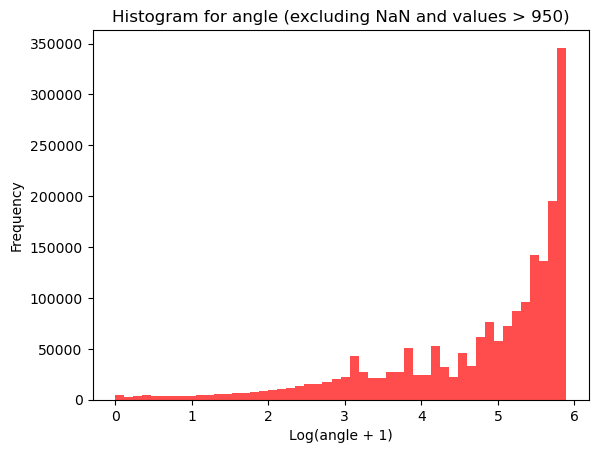

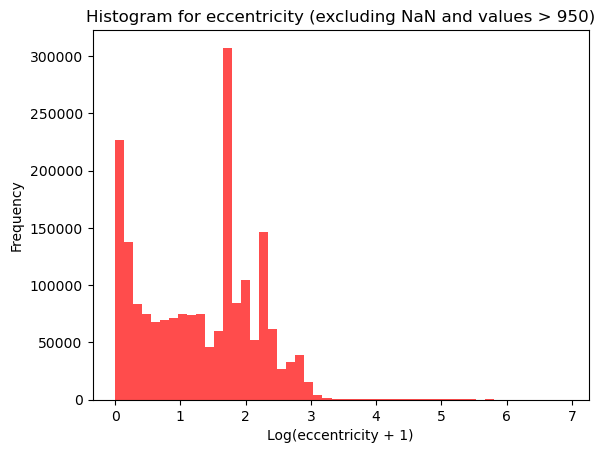

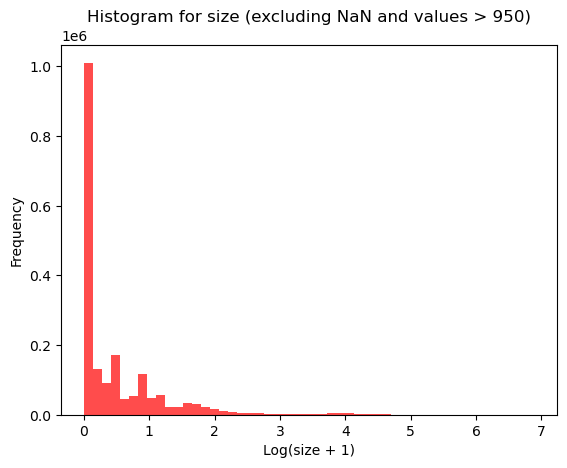

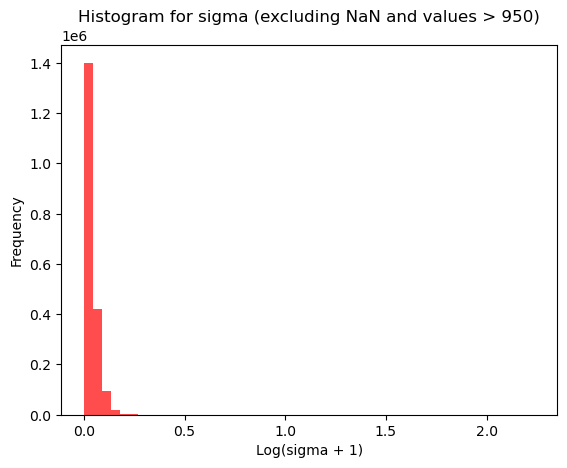

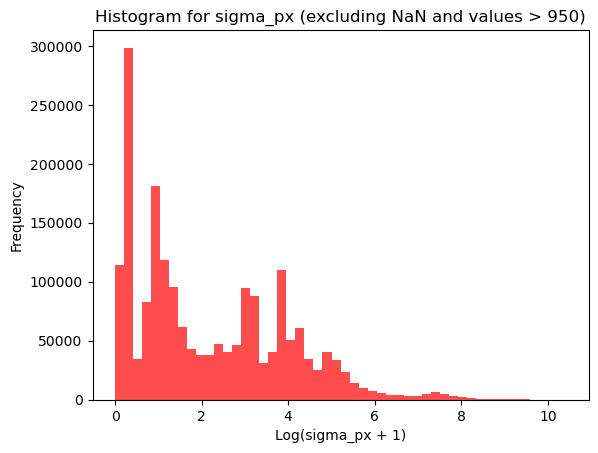

/home/rfpred/funcs/rf_tools.py:111: RuntimeWarning: invalid value encountered in log1p
  plt.hist(np.log1p(value.flatten()), bins=num_bins, color='red', alpha=0.7)  # Using np.log1p to handle zero values


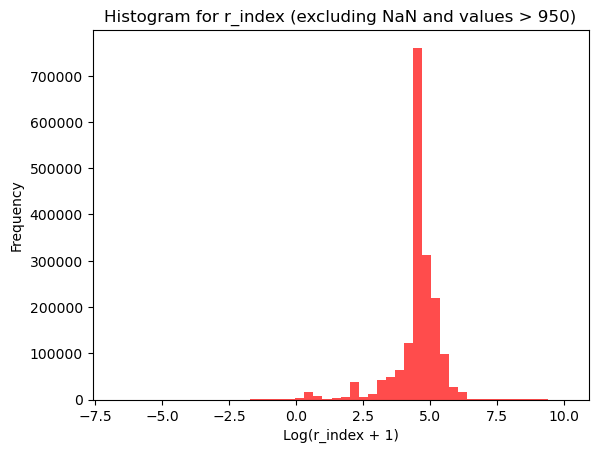

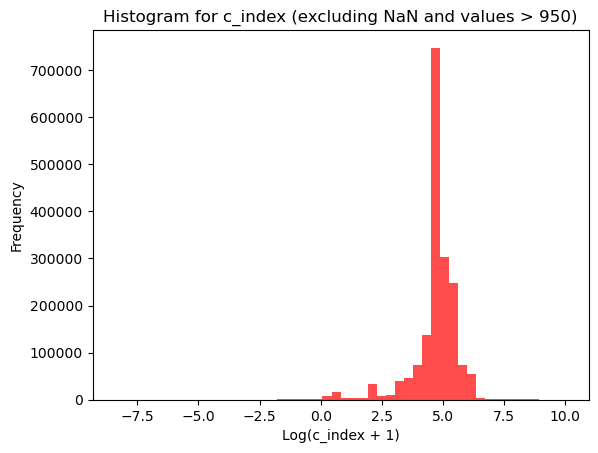

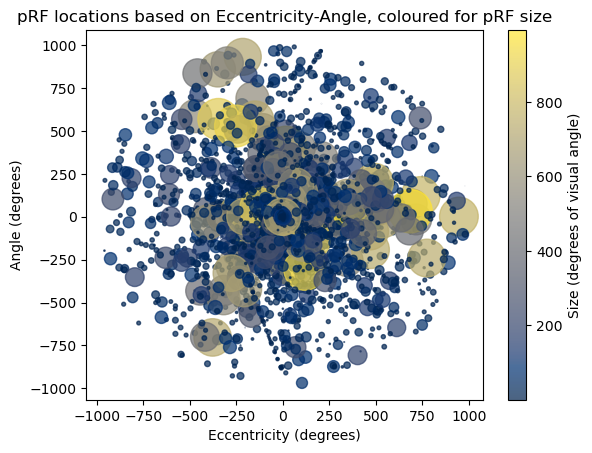

In [9]:
kak = prf_plots_new(1, bottom_percent=10)


In [84]:
import cv2
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from funcs.imgproc import show_stim
import cv2

def calculate_rms_contrast_circle(image_array, center, radius, hist='n', circ_plot='n'):
    """
    Calculate the Root Mean Square (RMS) contrast and fit a Weibull distribution to pixel intensities
    within a circular patch in a color image.

    Parameters:
    - image_array (numpy.ndarray): Input color image array of shape (height, width, channels).
    - center (tuple): Center coordinates of the circular patch (x, y).
    - radius (int): Radius of the circular patch.

    Returns:
    - tuple: (RMS contrast value within the circular patch, Weibull parameters, image with circle drawn,
              histogram plot, Weibull fit plot)
    """
    # Initialize an array to store RMS contrasts for each channel
    rms_contrasts = []

    # Loop over each channel
    for channel in range(image_array.shape[2]):
        # Extract the channel
        channel_image = image_array[:, :, channel]

        # Extract circular patch
        mask = np.zeros_like(channel_image)
        cv2.circle(mask, center, radius, 1, thickness=-1)  # Filled circle as a mask
        patch_pixels = channel_image[mask == 1]

        # Calculate mean intensity
        mean_intensity = np.mean(patch_pixels)

        # Calculate RMS contrast within the circular patch for the channel
        rms_contrast_channel = np.sqrt(np.mean((patch_pixels - mean_intensity) ** 2))

        # Append the result for the current channel
        rms_contrasts.append(rms_contrast_channel)

    # Calculate the mean RMS contrast across channels
    rms_contrast = np.mean(rms_contrasts)

    weibull_params = None
    image_with_circle = None

    if hist == 'y':
        # Plot contrast histogram
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(patch_pixels, bins=50, density=True, color='lightblue', alpha=0.7)
        plt.title('Contrast Histogram')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        # Plot Weibull fit
        
        # Fit a Weibull distribution to pixel intensities
        weibull_params = weibull_min.fit(patch_pixels)
        plt.subplot(1, 2, 2)
        plt.hist(patch_pixels, bins=50, density=True, color='lightblue', alpha=0.7)
        x_range = np.linspace(min(patch_pixels), max(patch_pixels), 100)
        plt.plot(x_range, weibull_min.pdf(x_range, *weibull_params), 'r-', lw=2, label='Weibull Fit')
        plt.title('Contrast Histogram with Weibull Fit')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
        
    if circ_plot == 'y':
            # Draw circle on the original image
        image_with_circle = image_array.copy()
        cv2.circle(image_with_circle, center, radius, (0, 255, 0), thickness=2)  # Green circle

        # Display the image with the circle
        fig, ax = plt.subplots(figsize=(8.8, 8.8))
        ax.imshow(image_with_circle)
        ax.set_title('Natural Scene with highlighted pRF')
        ax.axis('off')  # Turn off axis
        plt.show()
        
    return rms_contrast, weibull_params, image_with_circle, mask, patch_pixels, mean_intensity


In [45]:
import numpy as np
# Colour alternative
def get_rms_contrast(ar_in, mask_w_in, rf_mask_in, normalise=True):
    """
    Calculate RMS contrast for grayscale or color input.

    Args:
    - ar_in (numpy.ndarray): Input image array (grayscale or color) of shape (height, width) or (height, width, channels).
    - mask_w_in (numpy.ndarray): Weighted receptive field (e.g., Gaussian), sums to one.
    - rf_mask_in (numpy.ndarray): Boolean mask of the receptive field.
    - normalise (bool, optional): Normalize the input image. Defaults to True.

    Returns:
    - float: RMS contrast value.
    """
    if normalise:
        ar_in = ar_in / np.max(ar_in)

    if ar_in.ndim == 3:
        # For color input, calculate RMS contrast for each channel separately
        rms_contrast_channels = []
        for channel in range(ar_in.shape[2]):
            square_contrast = np.square((ar_in[:, :, channel] - (ar_in[rf_mask_in][:, :, channel].mean())))
            msquare_contrast = (mask_w_in * square_contrast).sum()
            rms_contrast_channels.append(np.sqrt(msquare_contrast))
        
        # Take the mean RMS contrast across channels
        rms_contrast = np.mean(rms_contrast_channels)
    else:
        # For grayscale input
        square_contrast = np.square((ar_in - (ar_in[rf_mask_in].mean())))
        msquare_contrast = (mask_w_in * square_contrast).sum()
        rms_contrast = np.sqrt(msquare_contrast)

    return rms_contrast


In [62]:

def get_rms_contrast_og(ar_in,mask_w_in,rf_mask_in,normalise=True):

    """rms contrast, computing contrast with respect to uniform mean



    Args:

    ar_in (_type_): image array in

    mask_w_in (_type_): weighted receptive field (e.g. guass), sums to one

    rf_mask_in (_type_): boolean mask of receptive field

    normalise (bool, optional): _description_. Defaults to True.

    """
    # ar_gray = cv2.cvtColor(ar_in, cv2.COLOR_BGR2GRAY)
    ar_gray = np.mean(ar_in, axis = -1)
    ar_in = ar_gray
    
    if normalise == True:
        ar_in = ar_in/np.max(ar_in)
        
    

    
    square_contrast=np.square((ar_in-(ar_in[rf_mask_in].mean())))

    msquare_contrast=(mask_w_in*square_contrast).sum()
    # mean square contrast

    return(np.sqrt(msquare_contrast))
    # root mean square contrast
    
    


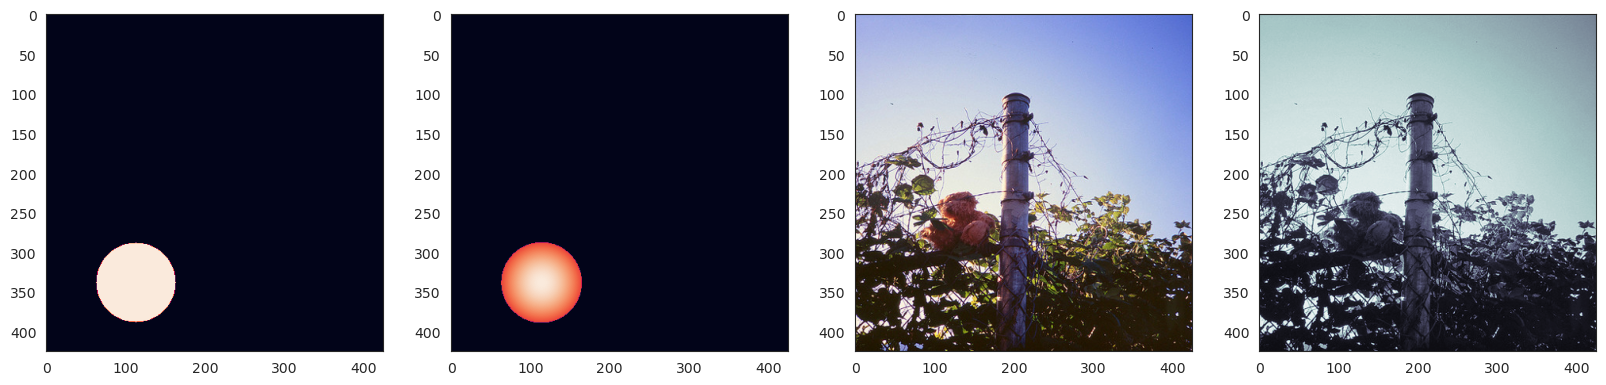

In [135]:
ar_in = show_stim(img_no = 104, hide = 'y')[0]
zaad = 12

rf_info = get_mask(dim = 425, subject = 'subj01', binary_masks = vismask_dict, 
                                        prf_proc_dict = prf_dict, type='cut_gaussian', roi='V2',
                                        plot = 'n', excl_reason = 'n', sigma_min=1, sigma_max = 1.2, rand_seed=zaad)

x, y = rf_info['x'].astype('int'), rf_info['y'].astype('int')
radius = rf_info['pix_radius'].astype('int')

mask_w_in = rf_info['mask']

rf_mask_in = get_mask(dim = 425, subject = 'subj01', binary_masks = vismask_dict, 
                                        prf_proc_dict = prf_dict, type='circle', roi='V2',
                                        plot = 'n', excl_reason = 'n', sigma_min=1, sigma_max = 1.2, rand_seed=zaad)['mask']

rf_mask_in = make_circle_mask(425, x, y, radius, fill = 'y', margin_width = 1)

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(rf_mask_in)
plt.subplot(1,4,2)
plt.imshow(mask_w_in)
plt.subplot(1,4,3)
plt.imshow(ar_in)
plt.subplot(1,4,4)
# plt.imshow(rf_mask_in*mask_w_in * np.mean(ar_in, axis = -1), cmap = 'bone')
# plt.imshow(np.mean(ar_in, axis = -1))
plt.imshow(cv2.cvtColor(ar_in, cv2.COLOR_BGR2GRAY), cmap = 'bone')
# print(rf_mask_in)

0.044363477217395475
0.0434325259515571
[31 23 37 ... 32 22 21]


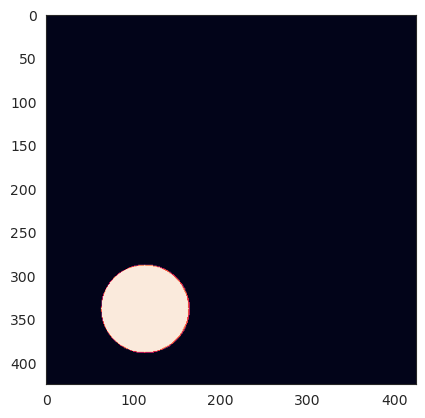

In [142]:

# print(rms_contrast)
image_array = ar_in

# Convert the image to grayscale
gray_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)

# Extract circular patch
mask = np.zeros_like(gray_image)
# mask = mask_w_in
cv2.circle(mask, (x,y), radius, 1, thickness=-1)  # Filled circle as a mask
patch_pixels = gray_image[mask == 1]

# Calculate mean intensity
mean_intensity = np.mean(patch_pixels)

# Calculate RMS contrast within the circular patch
rms_contrast = np.sqrt(np.mean((patch_pixels - mean_intensity)**2))

plt.imshow(mask_w_in)

print(mask_w_in.mean())
print(mask.mean())

print(patch_pixels)

In [82]:
# print(get_rms_contrast_og(ar_in, mask_w_in, rf_mask_in, normalise = True))
# print(get_rms_contrast(ar_in, mask_w_in, rf_mask_in, normalise = True))

print(get_rms_contrast_og(ar_in, rf_mask_in, rf_mask_in, normalise = True))
print(get_rms_contrast(ar_in, rf_mask_in, rf_mask_in, normalise = True))

40.26080067673184
47.85049942630136


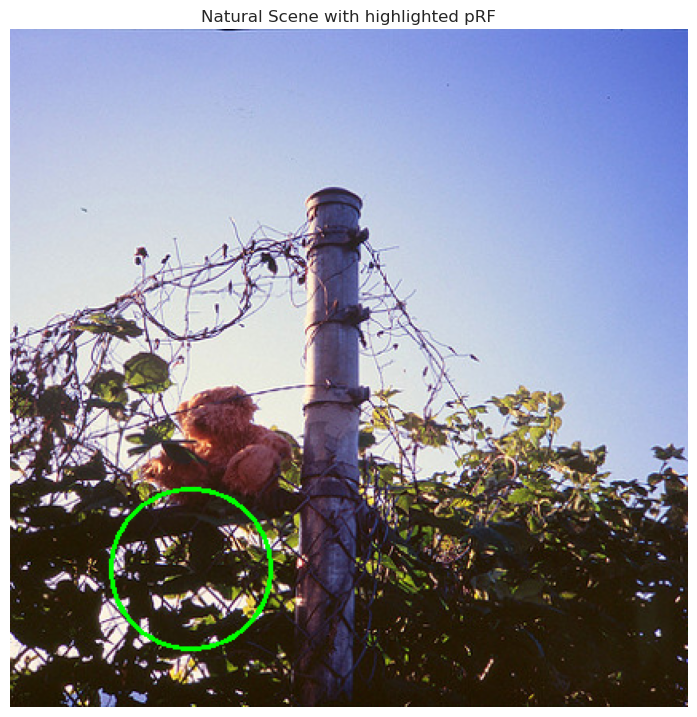

65.02596058042106


In [85]:
# from funcs.imgproc import calculate_rms_contrast_circle

center = (x, y)
rms, _, _, _, _, _ = calculate_rms_contrast_circle(ar_in, center, radius, hist = 'n', circ_plot = 'y')
print(rms)

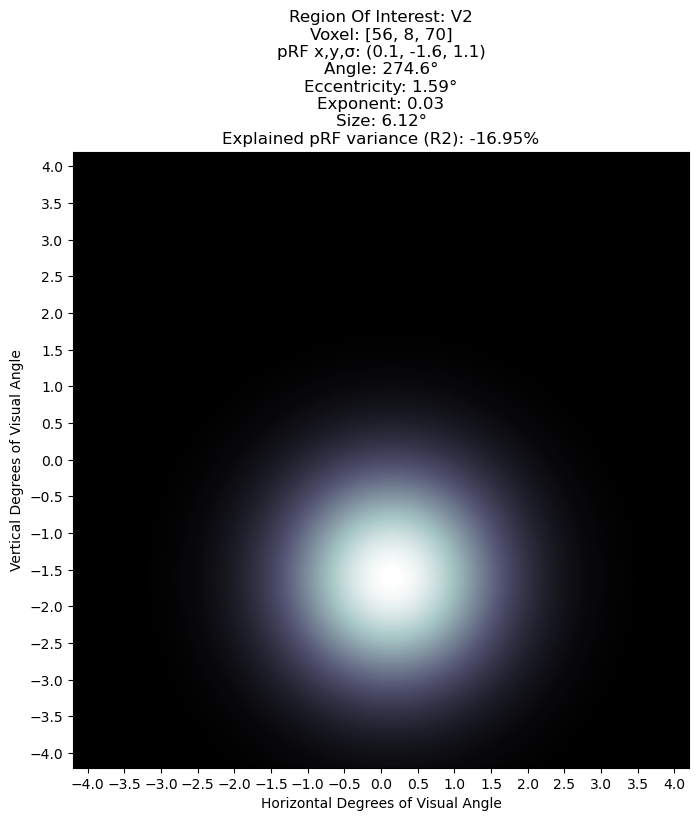

In [44]:
info = get_mask(dim = 425, subject = 'subj01', binary_masks = vismask_dict, 
                                        prf_proc_dict = prf_dict, type='gaussian', roi='V2',
                                        plot = 'y', excl_reason = 'n', sigma_min=1, sigma_max = 1.2, rand_seed=10)


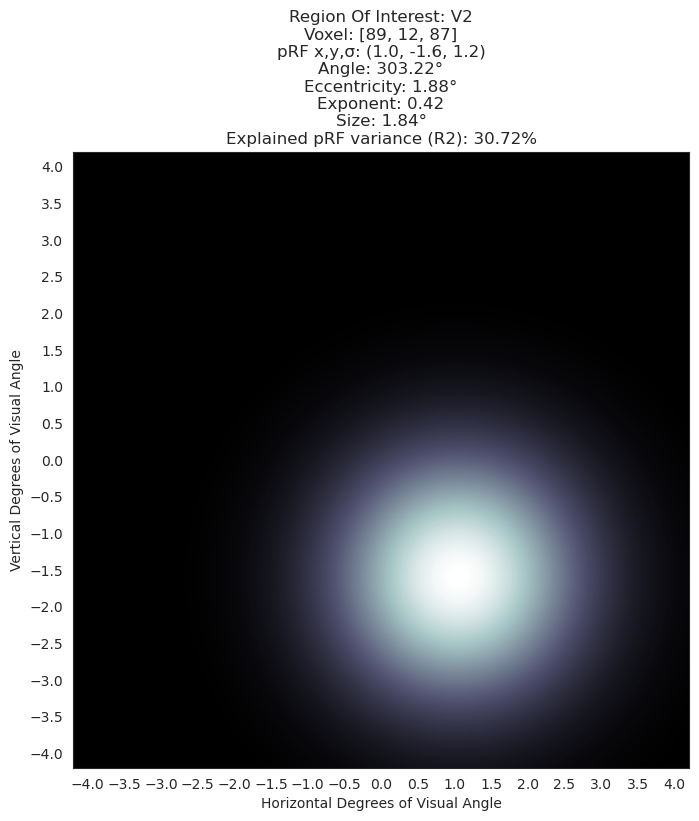

In [12]:
_ = get_mask(dim = 425, subject = 'subj01', binary_masks = vismask_dict, 
                                        prf_proc_dict = prf_dict, type='gaussian', roi='V2',
                                        plot = 'y', excl_reason = 'n', sigma_min=1, sigma_max = 1.2)


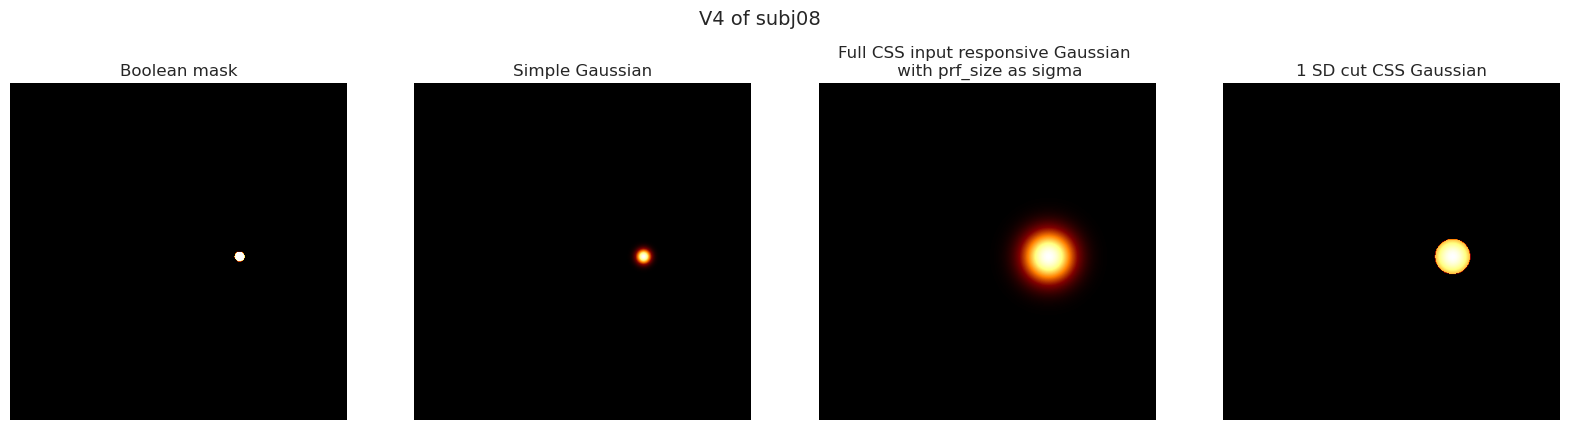

In [22]:
compare_masks(mask_dict = vismask_dict, prf_dict = prf_dict, subject='subj08', roi = 'V4', sigma_min = .1, sigma_max = 4.2, cmap = 'afmhot')

Subject: subj01, Voxel 1 out of 3976 found
Discarding pRF mask for voxel [97, 25, 60] due to:
   - r_index out of bounds
Subject: subj01, Voxel 2 out of 3976 found
Subject: subj01, Voxel 3 out of 3976 found
Subject: subj01, Voxel 4 out of 3976 found
Subject: subj01, Voxel 5 out of 3976 found
Subject: subj01, Voxel 6 out of 3976 found
Subject: subj01, Voxel 7 out of 3976 found
Subject: subj01, Voxel 8 out of 3976 found
Subject: subj01, Voxel 9 out of 3976 found
Subject: subj01, Voxel 10 out of 3976 found
Subject: subj01, Voxel 11 out of 3976 found
Subject: subj01, Voxel 12 out of 3976 found
Subject: subj01, Voxel 13 out of 3976 found
Discarding pRF mask for voxel [44, 26, 58] due to:
   - r_index out of bounds
   - c_index out of bounds
Subject: subj01, Voxel 14 out of 3976 found
Discarding pRF mask for voxel [104, 40, 69] due to:
   - c_index out of bounds
Subject: subj01, Voxel 15 out of 3976 found
Discarding pRF mask for voxel [103, 41, 70] due to:
   - c_index out of bounds
Subject:

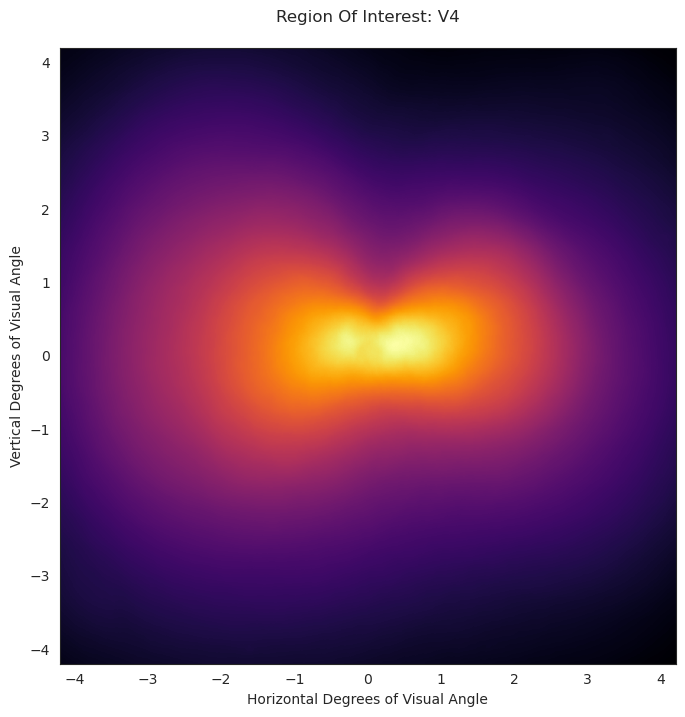

In [16]:
# Working heatmap call script.
start = time.time()

heatmap, iter, end_premat, roi = prf_heatmap('all', binary_masks=vismask_dict, prf_proc_dict=prf_dict, mask_type='cut_gaussian', cmap='inferno',\
                                  print_prog='y', roi='V4', sigma_min=0, sigma_max=4.2, subjects='all')

end = time.time()
print("Runtime:", np.round(end - start, 3), "seconds")

if end_premat is not True:
    print("There were", iter, "out of", np.sum(vismask_dict['subj01'][f'{roi}_mask']), "pRFs considered")

Subject: subj01, Voxel 1 out of 50 found
Subject: subj01, Voxel 2 out of 50 found
Subject: subj01, Voxel 3 out of 50 found
Subject: subj01, Voxel 4 out of 50 found
Subject: subj01, Voxel 5 out of 50 found
Subject: subj01, Voxel 6 out of 50 found
Subject: subj01, Voxel 7 out of 50 found
Subject: subj01, Voxel 8 out of 50 found
Subject: subj01, Voxel 9 out of 50 found
Subject: subj01, Voxel 10 out of 50 found
Subject: subj01, Voxel 11 out of 50 found
Subject: subj01, Voxel 12 out of 50 found
Subject: subj01, Voxel 13 out of 50 found
Subject: subj01, Voxel 14 out of 50 found
Subject: subj01, Voxel 15 out of 50 found
Subject: subj01, Voxel 16 out of 50 found
Subject: subj01, Voxel 17 out of 50 found
Subject: subj01, Voxel 18 out of 50 found
Subject: subj01, Voxel 19 out of 50 found
Subject: subj01, Voxel 20 out of 50 found
Subject: subj01, Voxel 21 out of 50 found
Subject: subj01, Voxel 22 out of 50 found
Subject: subj01, Voxel 23 out of 50 found
Subject: subj01, Voxel 24 out of 50 found
S

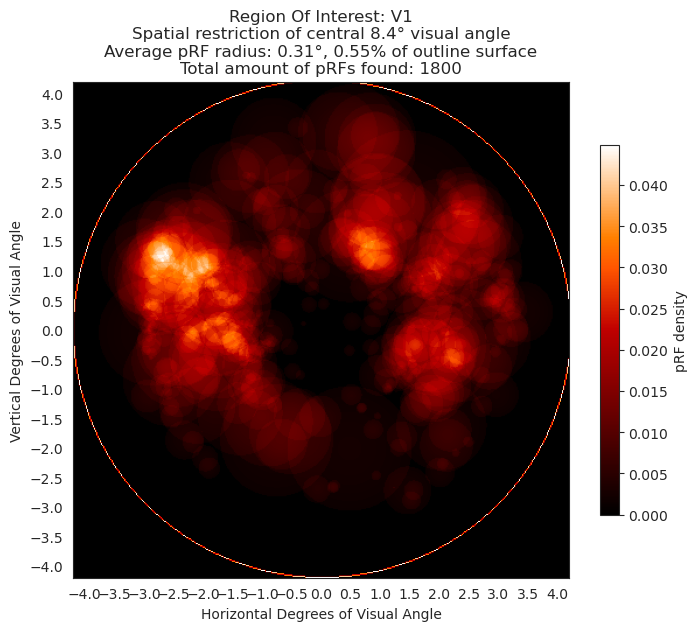

Runtime: 13.502 seconds
There were 60 out of 7887 pRFs considered


In [51]:
# Working heatmap call script.
import random
import time

start = time.time()

heatmap, iter, end_premat, roi, prf_sizes, avg_surf, total_prfs = prf_heatmap(50, binary_masks=vismask_dict, prf_proc_dict=prf_dict,
                                                        mask_type='cut_gaussian', cmap='gist_heat', print_prog='y', 
                                                        roi='V1', sigma_min=0, sigma_max = 4.2, ecc_max = 4.2, subjects='all', 
                                                        outline_degs = 4.2, fill_outline = 'n',
                                                        filter_dict = prf_rsq_dict, ecc_strict = 'y')

end = time.time()
print("Runtime:", np.round(end - start, 3), "seconds")

if end_premat is not True:
    print("There were", iter, "out of", np.sum(vismask_dict['subj01'][f'{roi}_mask']), "pRFs considered")

Subject: subj01, Voxel 1 out of 100 found
Subject: subj01, Voxel 2 out of 100 found
Subject: subj01, Voxel 3 out of 100 found
Subject: subj01, Voxel 4 out of 100 found
Subject: subj01, Voxel 5 out of 100 found
Subject: subj01, Voxel 6 out of 100 found
Subject: subj01, Voxel 7 out of 100 found
Subject: subj01, Voxel 8 out of 100 found
Subject: subj01, Voxel 9 out of 100 found
Subject: subj01, Voxel 10 out of 100 found
Subject: subj01, Voxel 11 out of 100 found
Subject: subj01, Voxel 12 out of 100 found
Subject: subj01, Voxel 13 out of 100 found
Subject: subj01, Voxel 14 out of 100 found
Subject: subj01, Voxel 15 out of 100 found
Subject: subj01, Voxel 16 out of 100 found
Subject: subj01, Voxel 17 out of 100 found
Subject: subj01, Voxel 18 out of 100 found
Subject: subj01, Voxel 19 out of 100 found
Subject: subj01, Voxel 20 out of 100 found
Subject: subj01, Voxel 21 out of 100 found
Subject: subj01, Voxel 22 out of 100 found
Subject: subj01, Voxel 23 out of 100 found
Subject: subj01, Vox

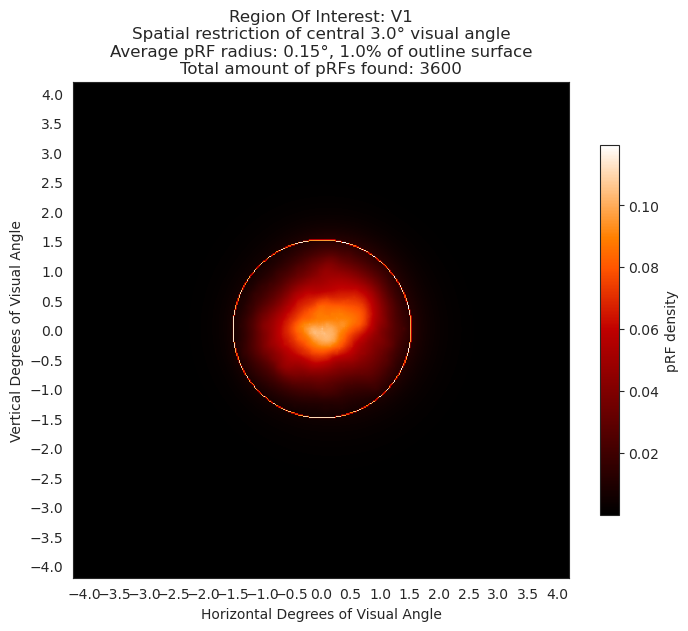

Runtime: 20.209 seconds
There were 363 out of 7887 pRFs considered


In [26]:
# Working heatmap call script.
import time
import numpy as np
start = time.time()

heatmap, iter, end_premat, roi, prf_sizes, relative_surf, total_prfs = prf_heatmap(100, binary_masks=vismask_dict, prf_proc_dict=prf_dict, 
                                                                                   mask_type='full_gaussian', cmap='gist_heat', print_prog='y', 
                                                                                   roi='V1', sigma_min=0, sigma_max=2, ecc_max = 1.5, outline_degs = 1.5, subjects='all', ecc_strict = 'y')

end = time.time()
print("Runtime:", np.round(end - start, 3), "seconds")

if end_premat is not True:
    print("There were", iter, "out of", np.sum(vismask_dict['subj01'][f'{roi}_mask']), "pRFs considered")

[[0.03215 0.0322  0.03225 0.0323  0.03235 0.03286 0.03306 0.03326 0.03346
  0.03351 0.03371 0.03421 0.03441 0.03445 0.0345  0.03469 0.03473 0.03492
  0.03511 0.03545 0.03564 0.03567 0.03585 0.03589 0.03576 0.03595 0.03583
  0.03586 0.03604 0.03622 0.03625 0.03627 0.0363  0.03648 0.03636 0.03624
  0.03643 0.03662 0.03665 0.03668 0.03672 0.0369  0.03724 0.03727 0.0373
  0.03749 0.03752 0.0377  0.03773 0.03791 0.03794 0.03797 0.0383  0.03833
  0.03852 0.0387  0.03888 0.03907 0.0391  0.03913 0.03932 0.0392  0.03923
  0.03925 0.03928 0.03931 0.03934 0.03937 0.0394  0.03928 0.03961 0.03963
  0.03966 0.03968 0.03956 0.03958 0.03961 0.03963 0.03966 0.03938 0.0397
  0.03973 0.03975 0.03977 0.03979 0.03981 0.03999 0.04    0.04002 0.04019
  0.04036 0.04053 0.04054 0.04071 0.04088 0.04089 0.0409  0.04091 0.04107
  0.04124 0.04155 0.04158 0.04175 0.04163 0.04165 0.04167 0.04183 0.04199
  0.0423  0.0423  0.04229 0.04228 0.04227 0.04226 0.04224 0.04207 0.04207
  0.04207 0.04192 0.04192 0.04207 0.0420

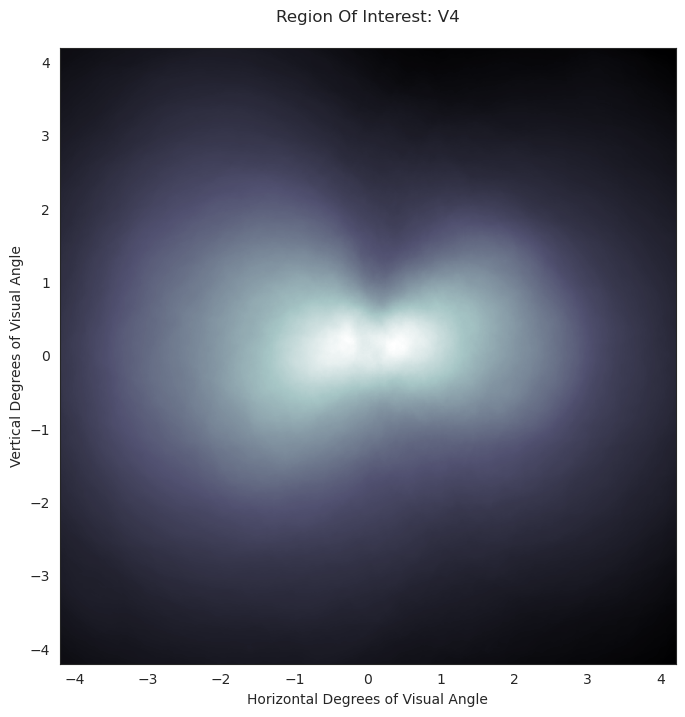

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(heatmap, cmap='bone', origin='lower', extent=[-4.2, 4.2, -4.2, 4.2])
ax.set_title(f'Region Of Interest: {roi}\n')
ax.set_xlabel('Horizontal Degrees of Visual Angle')
ax.set_ylabel('Vertical Degrees of Visual Angle')

with np.printoptions(threshold=np.inf):
    print(heatmap)



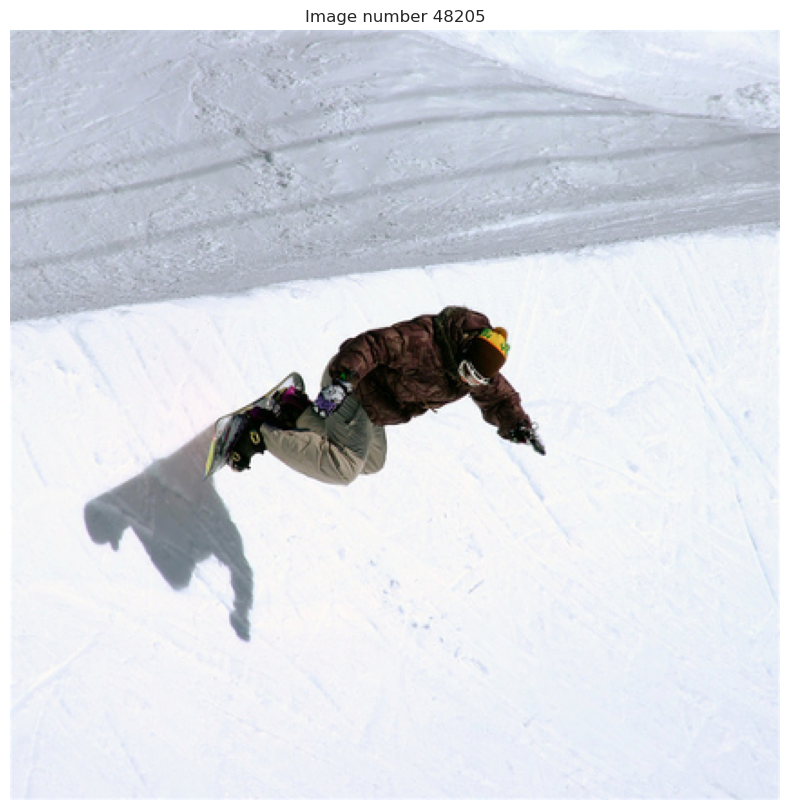

In [14]:
stim_img, img_no = show_stim()

This one is to test the heatmap function, however, this only works if the heatmap is of pretty much all the voxels of all the subjects, otherwise almost nothing can be seen. This is due to the fact that the values are based on the grand average of all the values. 

In [15]:
get_img_prf(stim_img, type='heatmask', binary_masks = vismask_dict, 
            prf_proc_dict = prf_dict, roi = 'V1', sigma_min = .1, 
            sigma_max = 4.2, heatmask=heatmap)

NameError: name 'heatmap' is not defined

In [1]:
get_img_prf(test_image, type='cut_gaussian', binary_masks = vismask_dict, 
            prf_proc_dict = prf_dict, roi = 'V1', sigma_min = .1, 
            sigma_max = 4.2, heatmask=heatmap)

NameError: name 'get_img_prf' is not defined

In [3]:
# !{sys.executable} -m pip install nibabel
# !{sys.executable} -m pip install prettyprint

# !{sys.executable} -m pip install h5py
# !{sys.executable} -m pip install numpy


# import nibabel as nib


# Requirement already satisfied: nibabel in /home/rfpred/envs/rfenv/lib/python3.11/site-packages (5.2.0)
# Requirement already satisfied: numpy>=1.20 in /home/rfpred/envs/rfenv/lib/python3.11/site-packages (from nibabel) (1.26.3)
# Requirement already satisfied: packaging>=17 in /home/rfpred/envs/rfenv/lib/python3.11/site-packages (from nibabel) (23.2)

/bin/bash: line 1: {sys.executable}: command not found


In [1]:
!{sys.executable} -m pip install nsdcode

# !{sys.executable} -m pip install -r requirements.txt




/bin/bash: line 1: {sys.executable}: command not found
